In [ ]:
import pandas as pd
import re
biometrics = pd.read_csv('../data_cleaned/biometrics_cleaned.csv', low_memory=False)

/var/folders/3f/hpgbw8dd459305qvgctxmywc0000gn/T/ipykernel_78465/292192285.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  biometrics = pd.read_csv('../data_cleaned/biometrics_cleaned.csv')


In [2]:
distinct_biometrics_count = biometrics['BiometricName'].nunique()
measurements_count_per_biometric = biometrics['BiometricName'].value_counts()
print(f"Number of distinct biometrics: {distinct_biometrics_count}")
print("Number of measurements for each biometric:")
print(measurements_count_per_biometric)

Number of distinct biometrics: 135
Number of measurements for each biometric:
BiometricName
Weight                        125751
Fat mass Perc                 111533
BMI                           111168
Muscle Mass                   100255
Total Body Water Perc          99970
                               ...  
Rpm Threshold                     10
Cycling training expertise         5
1RM Legs                           3
1RM Back                           2
Rowing Max Power                   1
Name: count, Length: 135, dtype: int64


## Cleaning

- Delete rows which have features with less than 50 measurements

In [ ]:
# Filter biometrics with less than 50 measurements
biometrics_less_than_50 = measurements_count_per_biometric[measurements_count_per_biometric < 50]
# Count how many biometrics have less than 50 measurements
count_biometrics_less_than_50 = biometrics_less_than_50.count()
print(f"Number of biometrics with less than 50 measurements: {count_biometrics_less_than_50}")
print("Biometrics with less than 50 measurements:")
print(biometrics_less_than_50)

Number of biometrics with less than 50 measurements: 12
Biometrics with less than 50 measurements:
BiometricName
1RM Leg Curl Biostrength          43
1RM Shoulder Press Biostrength    40
Range of motion                   38
1RM Leg Press Biostrength         34
1RM Lower Back Biostrength        28
VO2 Max                           14
1RM Med                           12
Rpm Threshold                     10
Cycling training expertise         5
1RM Legs                           3
1RM Back                           2
Rowing Max Power                   1
Name: count, dtype: int64


### Check how spread out they are

In [4]:
biometrics.drop_duplicates(subset=['CloudId', 'BiometricName', 'MeasuredOnUTC', 'Value'], keep='first', inplace=True)

def clean_timestamp(ts_str):
    clean_str = re.sub(r'(\d+:\d+:\d+)(\.\d+)?', r'\1', ts_str)
    return clean_str

biometrics['MeasuredOn'] = biometrics['MeasuredOnUTC'].apply(clean_timestamp)
biometrics['MeasuredOn'] = pd.to_datetime(biometrics['MeasuredOn'], errors='coerce')
biometrics['MeasuredOnDate'] = biometrics['MeasuredOn'].dt.date
biometrics['MeasuredOnDay'] = biometrics['MeasuredOn'].dt.dayofyear
biometrics['MeasuredOnWeek'] = biometrics['MeasuredOn'].dt.isocalendar().week
biometrics['MeasuredOnYear'] = biometrics['MeasuredOn'].dt.year
biometrics.sort_values('MeasuredOnWeek', inplace=True)

In [ ]:
bms = biometrics.drop(columns=['Age', 'Gender', 'MeasureProvidedBy', 'MeasuredOnUTC', 'MeasuredOn', 'MeasuredOnDate', 'MeasuredOnYear'])
bms = bms.groupby(['CloudId', 'BiometricName', 'MeasuredOnWeek']).agg({'Value': 'mean'}).reset_index()
grouped_bms = bms.groupby(['CloudId', 'BiometricName']).agg({'MeasuredOnWeek': [list, 'count'], 'Value': list})
grouped_bms = grouped_bms.reset_index()
grouped_bms.sample(5)

,CloudId,BiometricName,MeasuredOnWeek,Value
2172736,94634076ada2c2f7c649a79acc69cc65cd20cfb1,Extra Cellular Water Perc,30,42.90
2762593,bf959144e5a76e65cb499dc6e585b79dc091d85d,Right Arm Fat Perc,29,26.20
3707592,fec2dcbbac9ab2ac1b7517a66e391b0d12be2614,Degree Of Obesity Perc,42,20.22
2919523,c9ff9b8ce869fe8e52375d67292a79aca2eb4408,Weight,20,69.90
2237194,991c9562a51dea005f3006f3bec96b6067ed525b,Intra Cellular Water,41,24.70


### Keep only the biometrics and the users for which we have data for more than 6 months and more than 5 measurements

In [11]:
### More than 5 measurements the last 6 months
has_long_interval = grouped_bms[('MeasuredOnWeek', 'list')].apply(lambda x: max(x) - min(x) >= 24)
has_many_measurements = grouped_bms[('MeasuredOnWeek', 'count')] > 5
print(f'Total number of (CloudId, BiometricName) pairs: {len(grouped_bms)}')
print(f'Number of pairs with long interval: {has_long_interval.sum()} ({has_long_interval.sum() / len(grouped_bms) * 100:.2f}%)')
print(f'Number of pairs with many measurements: {has_many_measurements.sum()} ({has_many_measurements.sum() / len(grouped_bms) * 100:.2f}%)')
print(f'Number of pairs with both long interval and many measurements: {(has_long_interval & has_many_measurements).sum()} ({(has_long_interval & has_many_measurements).sum() / len(grouped_bms) * 100:.2f}%)')
filtered_group_bms = grouped_bms[has_long_interval & has_many_measurements]

Total number of (CloudId, BiometricName) pairs: 311337
Number of pairs with long interval: 270771 (86.97%)
Number of pairs with many measurements: 220332 (70.77%)
Number of pairs with both long interval and many measurements: 217258 (69.78%)


In [12]:
biometrics['BiometricName'].nunique()

135

In [ ]:
# Extract the CloudId and BiometricName pairs from filtered_group_bms
filtered_pairs = filtered_group_bms[[('CloudId', ''), ('BiometricName', '')]]
filtered_pairs.columns = ['CloudId', 'BiometricName']
filtered_biometrics = biometrics.merge(filtered_pairs, on=['CloudId', 'BiometricName'])
filtered_biometrics

,CloudId,Gender,Age,BiometricName,MeasureProvidedBy,MeasuredOnUTC,Value,MeasuredOn,MeasuredOnDate,MeasuredOnDay,MeasuredOnWeek,MeasuredOnYear
0,0113b3e68634143c440dc465186c2e25d57f0eeb,M,52,BMI,NaN,2022-01-07 09:07:52.598000+00:00,24.5,2022-01-07 09:07:52+00:00,2022-01-07,7,1,2022
1,2d00ff6ab4168b4717161b677de4e6c606258fc7,M,35,Basal Metabolic Rate,NaN,2022-01-04 14:39:01.815000+00:00,1576.0,2022-01-04 14:39:01+00:00,2022-01-04,4,1,2022
2,2d00ff6ab4168b4717161b677de4e6c606258fc7,M,35,Extra Cellular Water,NaN,2022-01-04 14:39:01.815000+00:00,16.0,2022-01-04 14:39:01+00:00,2022-01-04,4,1,2022
3,2d00ff6ab4168b4717161b677de4e6c606258fc7,M,35,Intra Cellular Water,NaN,2022-01-04 14:39:01.815000+00:00,23.4,2022-01-04 14:39:01+00:00,2022-01-04,4,1,2022
4,2d00ff6ab4168b4717161b677de4e6c606258fc7,M,35,Metabolic Age,NaN,2022-01-04 14:39:01.815000+00:00,19.0,2022-01-04 14:39:01+00:00,2022-01-04,4,1,2022
...,...,...,...,...,...,...,...,...,...,...,...,...
4555152,51b5960158c7aa439189fe87d256540062a69c4e,M,43,Height,NaN,2022-12-31 15:08:33.637000+00:00,176.0,2022-12-31 15:08:33+00:00,2022-12-31,365,52,2022
4555153,51b5960158c7aa439189fe87d256540062a69c4e,M,43,Trunk Fat Perc,NaN,2022-12-31 15:08:33.637000+00:00,27.1,2022-12-31 15:08:33+00:00,2022-12-31,365,52,2022
4555154,51b5960158c7aa439189fe87d256540062a69c4e,M,43,Left Leg Fat Perc,NaN,2022-12-31 15:08:33.637000+00:00,27.5,2022-12-31 15:08:33+00:00,2022-12-31,365,52,2022
4555155,f47d83eb9ed2343809a032d4b3b0c3206804a7e6,F,60,Extra Cellular Water Perc,NaN,2022-12-31 12:49:42.567000+00:00,45.2,2022-12-31 12:49:42+00:00,2022-12-31,365,52,2022


In [14]:
filtered_biometrics['BiometricName'].nunique()

117

## More exploration
----------------------------

In [ ]:
# Group by BiometricName and CloudId, then count the measurements
measurements_per_user = biometrics.groupby(['BiometricName', 'CloudId']).size().reset_index(name='Count')
# Calculate the average number of measurements per user for each biometric
average_measurements = measurements_per_user.groupby('BiometricName')['Count'].mean().reset_index(name='AverageMeasurements')
print(average_measurements)

                     BiometricName  AverageMeasurements
0                         1RM Back             1.000000
1      1RM Chest Press Biostrength            10.375000
2         1RM Leg Curl Biostrength             6.142857
3    1RM Leg Extension Biostrength             8.000000
4        1RM Leg Press Biostrength             5.666667
..                             ...                  ...
130            Visceral Fat Rating            15.911711
131            Waist Circumference            10.786992
132                Waist-Hip ratio            11.373737
133                         Weight            20.328322
134                 Weight Control            11.373737

[135 rows x 2 columns]


In [36]:
bms = biometrics.drop(columns=['Age', 'Gender', 'MeasureProvidedBy', 'MeasuredOnUTC', 'MeasuredOn', 'MeasuredOnDate', 'MeasuredOnYear'])
bms = bms.groupby(['CloudId', 'BiometricName', 'MeasuredOnWeek']).agg({'Value': 'mean'}).reset_index()
bms.sample(5)

,CloudId,BiometricName,MeasuredOnWeek,Value
1833215,7dba2bf05c476b4b60f01afb1f36c23e557ade11,Standard Muscle Mass Perc,48,51.900
629550,2bc905f527f0a7e6de14384c3c61182960b4924b,Left Arm Fat Free Mass,26,3.100
518796,24ac276329b1fa5d86282c6bc39c4ceb94281381,Right Arm Muscle Mass Score,18,1.000
582642,290084ef94d3bc09e02bf2bac15775f8ae5419e7,Right Leg Fat Free Mass,10,8.960
3125134,d85785304a1f2a49f80da82a717e7ba67feb91bb,Fat Mass Perc of Ideal Left Leg,2,119.745


<Axes: xlabel='BiometricName'>

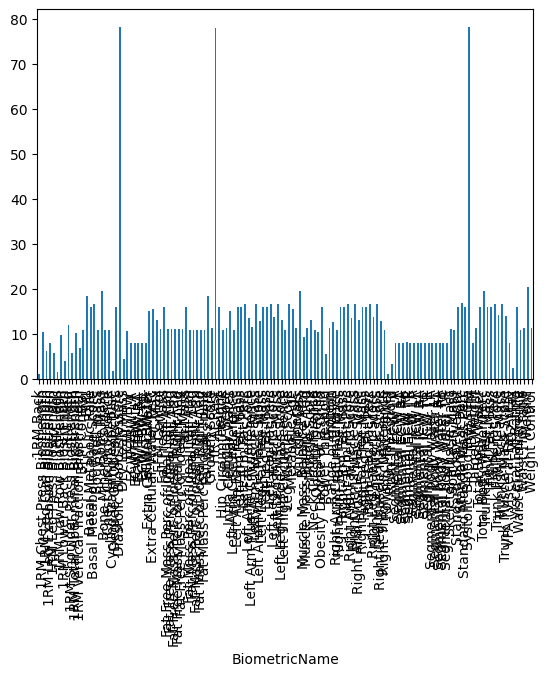

In [5]:
average_measurements.plot(kind='bar', x='BiometricName', y='AverageMeasurements', legend=False)

<Axes: xlabel='BiometricName'>

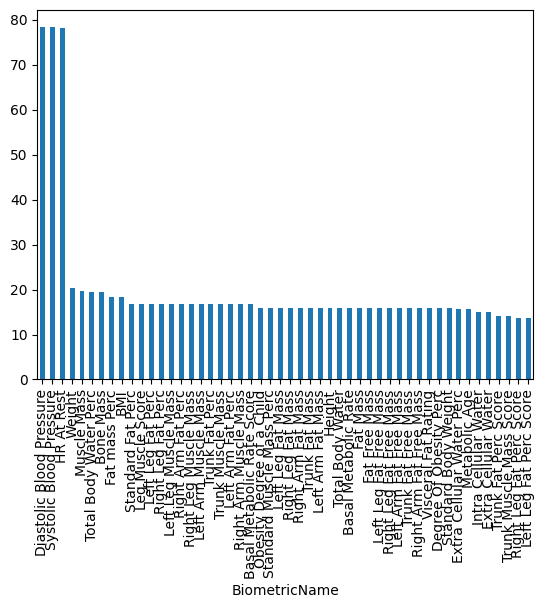

In [ ]:
# Plot only the first 50 biometrics
average_measurements.nlargest(50, 'AverageMeasurements').plot(kind='bar', x='BiometricName', y='AverageMeasurements', legend=False)

In [ ]:
# Convert 'MeasuredOnUTC' to datetime
biometrics['MeasuredOnUTC'] = pd.to_datetime(biometrics['MeasuredOnUTC'])
# Group by CloudId and MeasuredOnUTC (week), then count distinct BiometricName
distinct_biometrics_per_week = biometrics.groupby(['CloudId', pd.Grouper(freq='W', key='MeasuredOnUTC')])['BiometricName'].nunique().reset_index(name='DistinctBiometricsCount')
# Calculate the average number of distinct biometric measurements per user per week
average_distinct_biometrics_per_user_per_week = distinct_biometrics_per_week.groupby('CloudId')['DistinctBiometricsCount'].mean().reset_index(name='AverageDistinctBiometricsPerWeek')
average_distinct_biometrics_per_user_per_week

,CloudId,AverageDistinctBiometricsPerWeek
0,0015d65e3205deb6bb6a8f0d57cc48547918f0f2,20.900000
1,00178b2158754ab401cb57efb5c3be8289e052e6,52.500000
2,0022b439d0d622b758a0e9d0a8c8ea47c9d4f871,47.833333
3,0024a5d2cf20efc70369e4736d130e270618ce0a,52.733333
4,002d61779b8054ee528795d2031281b7a569acba,55.000000
...,...,...
6355,ffd3c4660510f1a79abb8c5f4b6120c4a94aa76f,55.000000
6356,ffeea0a77c263943ced4ac8a29adfd5743d3de30,55.000000
6357,fff230cce3b74f2c406bd00cb07e23d4c086328b,34.000000
6358,fff2731bc33232aa42d205e88c6bcfef052e642c,43.848485


In [18]:
# Filter users with more than 50 measurements per week on average
users_more_than_50_measurements = average_distinct_biometrics_per_user_per_week[average_distinct_biometrics_per_user_per_week['AverageDistinctBiometricsPerWeek'] > 40]

# Count the number of such users
count_users_more_than_50 = users_more_than_50_measurements.shape[0]

print(f"Number of users with more than 50 measurements per week on average: {count_users_more_than_50}")

Number of users with more than 50 measurements per week on average: 5158


__________________________________

Still have to explore whether those are the same measurements. Do we have 20 distinct measurements in a week for different attributes or for the same? Are they the same biometrics over the weeks?

In [ ]:
# store as pickle file
filtered_biometrics.to_pickle('filtered_biometrics.pkl')